In [1]:
import numpy as np
from numpy import float32
import warnings
import os
import glob
import tensorflow as tf
import cv2
from sklearn import utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from utils import *
from data_augmentation import *
from feature_extractor import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
IMG_SIZE=128

In [21]:
TRAIN_DATA_DIR = './lstm_data/train'
VAL_DATA_DIR = './lstm_data/val'
TEST_DATA_DIR = './lstm_data/test'

AUG_TRAIN_DATA_DIR = './lstm_data_augmented/train'
AUG_VAL_DATA_DIR = './lstm_data_augmented/val'
AUG_TEST_DATA_DIR = './lstm_data_augmented/test'

In [22]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [30]:
def augment_train_data(data_category):
    data_path = f'{TRAIN_DATA_DIR}/{data_category}'
    aug_data_path = f'{AUG_TRAIN_DATA_DIR}/{data_category}'
    delete_files(aug_data_path)
    # delete_files(f'{AUG_TRAIN_DATA_DIR}/negative')
    
    for subdir, dirs, files in os.walk(data_path):
        for file in files:
            filepath = os.path.join(subdir, file)
            file_folder = filepath.rsplit('/')[-2]
            original_img_sequence_folder_path = f'{aug_data_path}/{file_folder}'
            fliplr_img_sequence_folder_path = f'{aug_data_path}/{file_folder}_fliplr'
            flipud_img_sequence_folder_path = f'{aug_data_path}/{file_folder}_flipud'
            
            if not os.path.exists(original_img_sequence_folder_path):
                os.makedirs(original_img_sequence_folder_path)
            if not os.path.exists(fliplr_img_sequence_folder_path):
                os.makedirs(fliplr_img_sequence_folder_path)
            if not os.path.exists(flipud_img_sequence_folder_path):
                os.makedirs(flipud_img_sequence_folder_path)
            
            img = np.load(filepath)
            fliplr_img = np.fliplr(img)
            flipud_img = np.flipud(img)
            cut_filename = file.rsplit('.', 1)[0]
            
            original_img_save = os.path.join(original_img_sequence_folder_path, cut_filename)
            fliplr_img_save = os.path.join(fliplr_img_sequence_folder_path, f'{cut_filename}')
            flipud_img_save = os.path.join(flipud_img_sequence_folder_path, f'{cut_filename}')

            np.save(original_img_save, img)
            np.save(fliplr_img_save, fliplr_img)
            np.save(flipud_img_save, flipud_img)

In [32]:
# augment_train_data('positive')

In [8]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, folder_paths,
                 batch_size,
                 input_size=(6, 128, 128),
                 shuffle=True):
        
        self.folder_paths = folder_paths.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.folder_paths)
        self.n_category = 2
        # self.n_name = df[y_col['name']].nunique()
        # self.n_type = df[y_col['type']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.folder_paths)
    
    def __getitem__(self, index):
        batches = self.folder_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)  
        X = np.expand_dims(X, axis=4)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __get_input(self, folder):
        images = []
        for subdir, dirs, files in os.walk(folder):
            for f in files:
                images.append(os.path.join(subdir, f.decode(encoding='UTF-8')))
        images = sorted(images)
        # for im in images:
        #     print(im)
        # images = [preprocessing.normalize(np.load(x)) for x in images]
        images = [preprocessing.normalize(np.load(x)) for x in images]
        if len(images) != 6:
            print(folder)
        images = [cv2.resize(x, (128, 128), interpolation = cv2.INTER_AREA) for x in images]
        return np.array(images)

    def __get_output(self, path, num_classes=2):
        label = None
        folder = path.rsplit('/')[-2]
        if folder == 'positive':
            label = 1
        elif folder == 'negative':
            label = 0
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        # path_batch = batches[self.X_col['path']]
        # category_batch = batches[self.y_col['type']]
        # print(batches)
        X_batch = np.asarray([self.__get_input(x) for x in batches])
        y_batch = np.asarray([self.__get_output(y, self.n_category) for y in batches])

        return X_batch, y_batch

In [61]:
label = 1
tf.keras.utils.to_categorical(label, num_classes=2)

array([0., 1.], dtype=float32)

In [62]:
train_folders = []
for subdir, dirs, files in os.walk(TRAIN_DATA_DIR):
     for d in dirs:
            if d != 'positive' and d != 'negative':
                train_folders.append(os.path.join(subdir, d))
train_folders = np.array(train_folders)

val_folders = []
for subdir, dirs, files in os.walk(VAL_DATA_DIR):
     for d in dirs:
            if d != 'positive' and d != 'negative':
                val_folders.append(os.path.join(subdir, d))
val_folders = np.array(val_folders)

test_folders = []
for subdir, dirs, files in os.walk(TEST_DATA_DIR):
     for d in dirs:
            if d != 'positive' and d != 'negative':
                test_folders.append(os.path.join(subdir, d))
test_folders = np.array(test_folders)

In [63]:
epochs = 20
batch_size = 8

In [64]:
traingen = CustomDataGen(train_folders, batch_size)
valgen = CustomDataGen(val_folders, batch_size)

In [11]:
random_batch = np.random.randint(0, 209)
random_sample = np.random.randint(0, 8)
t = traingen[random_batch][0][random_sample]
print(f'batch {random_batch} sample {random_sample}')

batch 141 sample 2


In [12]:
def build_feature_extractor():
    feature_extractor = CustomResNet50(
        weights=None,
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 1),
    )
    # return feature_extractor

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))
    # preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(inputs)
    return Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
feature_extractor.load_weights('./checkpoints/my_checkpoint')

channels_last


2022-07-20 23:01:38.658100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 23:01:39.252082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6656 MB memory:  -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:82:00.0, compute capability: 7.5


In [14]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
Total params: 23,581,440
Trainable params: 23,528,320
Non-trainable params: 53,120
_________________________________________________________________


In [65]:
def get_features(generator):
    features = []
    for sample in generator:
        new_batch = []
        batch = sample[0]
        for b in batch:
            tmp_frame_features = feature_extractor.predict(b, verbose=0)
            new_batch.append(tmp_frame_features)
        features.append(np.array(new_batch))

    features = np.array(features)
    features = features.reshape(features.shape[0], features.shape[1], features.shape[2], features.shape[5])
    features = features.reshape(features.shape[0]*features.shape[1], features.shape[2], features.shape[3])

    return features

In [66]:
def get_labels(generator):
    labels = []

    for sample in generator:
        new_batch = []
        batch = sample[1]
        labels.append(batch)

    labels = np.array(labels)
    labels = labels.reshape(labels.shape[0]*labels.shape[1], labels.shape[2])
    
    return labels

In [67]:
train_x = get_features(traingen)
train_y = get_labels(traingen)

In [68]:
val_x = get_features(valgen)
val_y = get_labels(valgen)

In [69]:
train_x.shape

(1664, 6, 2048)

In [70]:
val_y.shape

(208, 2)

In [106]:
def get_sequence_model():
    inp = Input(shape=train_x.shape[1:])
    x = keras.layers.GRU(128, return_sequences=True)(inp)
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = Model(inp, output)
    adam_fine = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=adam_fine, metrics=["accuracy"]
    )
    return rnn_model

In [107]:
model = get_sequence_model()
model.fit(train_x, train_y, validation_data = (val_x, val_y), batch_size=64, epochs=50)

Epoch 1/50
26/26 [==============================] - 3s 38ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 3/50
26/26 [==============================] - 0s 12ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 8/50
26

In [94]:
testgen = CustomDataGen(test_folders, 64)
test_features = get_features(testgen)

In [95]:
model.predict(test_features)

6/6 [==============================] - 1s 3ms/step


array([[0.5006029 , 0.49939713],
       [0.5006976 , 0.49930236],
       [0.50080585, 0.49919412],
       [0.5006953 , 0.49930468],
       [0.50061554, 0.4993845 ],
       [0.500731  , 0.49926904],
       [0.50078416, 0.4992159 ],
       [0.50077546, 0.49922457],
       [0.5007383 , 0.49926168],
       [0.5009198 , 0.49908015],
       [0.5006397 , 0.49936032],
       [0.5008186 , 0.4991814 ],
       [0.5008161 , 0.49918383],
       [0.5006135 , 0.4993865 ],
       [0.5007936 , 0.49920642],
       [0.50081646, 0.49918354],
       [0.5008087 , 0.49919128],
       [0.50072116, 0.4992788 ],
       [0.5007878 , 0.49921218],
       [0.50079024, 0.4992098 ],
       [0.50086063, 0.49913934],
       [0.50083625, 0.49916375],
       [0.50076944, 0.4992306 ],
       [0.50077426, 0.49922577],
       [0.500809  , 0.49919096],
       [0.500786  , 0.49921402],
       [0.5008033 , 0.49919674],
       [0.50081974, 0.4991803 ],
       [0.50081456, 0.49918547],
       [0.5009117 , 0.49908826],
       [0.

In [149]:
# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

NameError: name 'label_processor' is not defined

In [105]:
#### Construct the input layer with no definite frame size.
inp = layers.Input(shape=(6, 64, 64, 1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
# )(x)

x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(2), activation="softmax")(x)


# x = Dense(128, activation='relu')(x)
# x = layers.GlobalAveragePooling3D()(x)
# x = Dense(2, activation='softmax')(x)

# Next, we will build the complete model and compile it.
model = Model(inp, x)

ValueError: Input 0 of layer "average_pooling2d" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 6, 64, 64, 64)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 64, 64, 1)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 6, 64, 64, 64)     416256    
                                                                 
 batch_normalization (BatchN  (None, 6, 64, 64, 64)    256       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 6, 64, 64, 64)     295168    
                                                                 
 batch_normalization_1 (Batc  (None, 6, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 6, 64, 64, 64)     33024 

./lstm_data/train/negative/AIA20120324_2251_0094/AIA20120324_2148_0094_0.npy
./lstm_data/train/negative/AIA20120324_2251_0094/AIA20120324_2154_0094_1.npy
./lstm_data/train/negative/AIA20120324_2251_0094/AIA20120324_2200_0094_2.npy
./lstm_data/train/negative/AIA20120324_2251_0094/AIA20120324_2206_0094_3.npy
./lstm_data/train/negative/AIA20120324_2251_0094/AIA20120324_2212_0094_4.npy
./lstm_data/train/negative/AIA20120324_2251_0094/AIA20120324_2218_0094_5.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0136_0094_0.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0142_0094_1.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0148_0094_2.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0154_0094_3.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0200_0094_4.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0206_0094_5.npy
./lstm_data/train/negative/AIA20170627_2109_0094/AIA20170627_2018_0094_0.npy

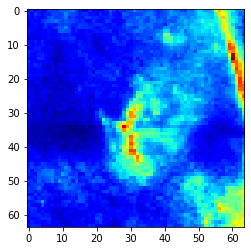

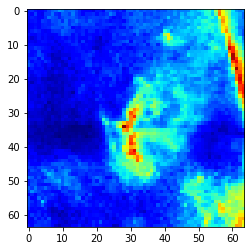

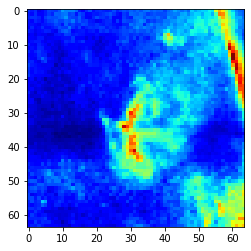

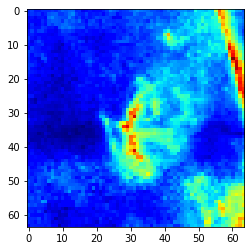

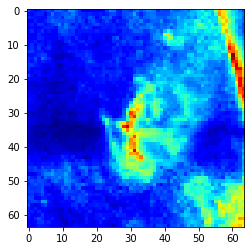

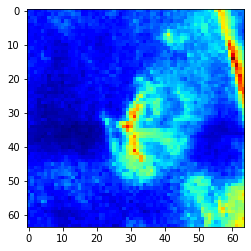

In [101]:
random_batch = np.random.randint(0, 209)
random_sample = np.random.randint(0, 8)
t = traingen[random_batch][0][random_sample]
print(f'batch {random_batch} sample {random_sample}')
# print(traingen[random_batch][1][random_sample])
# Construct a figure on which we will visualize the images.
# fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# # Plot each of the sequential images for one random data example.
# # data_choice = np.random.choice(range(len(x_train)), size=1)[0]
# for idx, ax in enumerate(axes.flat):
#     ax.imshow(t[idx], cmap='jet')
#     ax.set_title(f"Frame {idx + 1}")
#     ax.axis("off")
for i in t:
    plt.imshow(i, cmap='jet')
    plt.show()
# Print information and display the figure.
# plt.show()

./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0136_0094_0.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0142_0094_1.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0148_0094_2.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0154_0094_3.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0200_0094_4.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0206_0094_5.npy


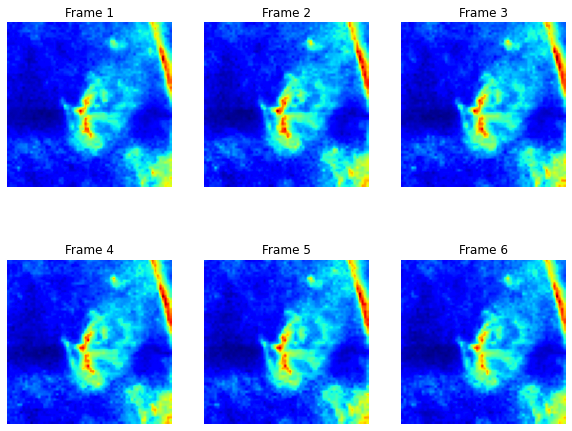

In [104]:
data_folder = './lstm_data/train/negative/AIA20180122_0237_0094'
paths = []
for subdir, dirs, files in os.walk(data_folder):
    for f in files:
        paths.append(os.path.join(subdir, f))
paths = sorted(paths)
for p in paths:
    print(p)

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(preprocessing.normalize(np.load(paths[idx]))), cmap='jet')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()

In [77]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(traingen, validation_data = valgen, epochs=epochs, verbose=2)

['./lstm_data/train/positive/AIA20150704_1501_0094/AIA20150704_1430_0094_0.npy', './lstm_data/train/positive/AIA20150704_1501_0094/AIA20150704_1436_0094_1.npy', './lstm_data/train/positive/AIA20150704_1501_0094/AIA20150704_1442_0094_2.npy', './lstm_data/train/positive/AIA20150704_1501_0094/AIA20150704_1448_0094_3.npy', './lstm_data/train/positive/AIA20150704_1501_0094/AIA20150704_1454_0094_4.npy', './lstm_data/train/positive/AIA20150704_1501_0094/AIA20150704_1500_0094_5.npy']
['./lstm_data/train/positive/AIA20160820_0551_0094/AIA20160820_0518_0094_0.npy', './lstm_data/train/positive/AIA20160820_0551_0094/AIA20160820_0524_0094_1.npy', './lstm_data/train/positive/AIA20160820_0551_0094/AIA20160820_0530_0094_2.npy', './lstm_data/train/positive/AIA20160820_0551_0094/AIA20160820_0536_0094_3.npy', './lstm_data/train/positive/AIA20160820_0551_0094/AIA20160820_0542_0094_4.npy', './lstm_data/train/positive/AIA20160820_0551_0094/AIA20160820_0548_0094_5.npy']
['./lstm_data/train/positive/AIA201210

KeyboardInterrupt: 

In [106]:
testgen = CustomDataGen(test_folders, batch_size)
predictions = model.predict(testgen)

./lstm_data/test/positive/AIA20170815_1611_0094/AIA20170815_1536_0094_0.npy
./lstm_data/test/positive/AIA20170815_1611_0094/AIA20170815_1542_0094_1.npy
./lstm_data/test/positive/AIA20170815_1611_0094/AIA20170815_1548_0094_2.npy
./lstm_data/test/positive/AIA20170815_1611_0094/AIA20170815_1554_0094_3.npy
./lstm_data/test/positive/AIA20170815_1611_0094/AIA20170815_1600_0094_4.npy
./lstm_data/test/positive/AIA20170815_1611_0094/AIA20170815_1606_0094_5.npy
./lstm_data/test/positive/AIA20150925_1658_0094/AIA20150925_1624_0094_0.npy
./lstm_data/test/positive/AIA20150925_1658_0094/AIA20150925_1630_0094_1.npy
./lstm_data/test/positive/AIA20150925_1658_0094/AIA20150925_1636_0094_2.npy
./lstm_data/test/positive/AIA20150925_1658_0094/AIA20150925_1642_0094_3.npy
./lstm_data/test/positive/AIA20150925_1658_0094/AIA20150925_1648_0094_4.npy
./lstm_data/test/positive/AIA20150925_1658_0094/AIA20150925_1654_0094_5.npy
./lstm_data/test/positive/AIA20151218_1529_0094/AIA20151218_1454_0094_0.npy
./lstm_data/

In [107]:
predictions

array([[0.49998513, 0.5000149 ],
       [0.4999845 , 0.5000155 ],
       [0.49998358, 0.5000164 ],
       [0.49998525, 0.5000148 ],
       [0.49998373, 0.5000163 ],
       [0.49998656, 0.5000135 ],
       [0.49998423, 0.5000158 ],
       [0.49998537, 0.5000146 ],
       [0.499984  , 0.50001603],
       [0.49998483, 0.50001514],
       [0.4999834 , 0.5000166 ],
       [0.49998477, 0.5000152 ],
       [0.49998412, 0.5000159 ],
       [0.49998423, 0.5000158 ],
       [0.4999843 , 0.5000157 ],
       [0.49998417, 0.50001585],
       [0.49998412, 0.5000159 ],
       [0.49998432, 0.5000157 ],
       [0.4999844 , 0.50001556],
       [0.49998388, 0.5000161 ],
       [0.4999837 , 0.50001633],
       [0.499984  , 0.50001603],
       [0.49998468, 0.5000153 ],
       [0.49998745, 0.5000126 ],
       [0.49998578, 0.50001425],
       [0.49998477, 0.5000152 ],
       [0.49998435, 0.5000156 ],
       [0.4999847 , 0.50001526],
       [0.49998528, 0.5000147 ],
       [0.49998486, 0.50001514],
       [0.

In [ ]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
  
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
   
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
def ResNet50(include_top=True, weights=None,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=2):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    #if weights == 'imagenet' and include_top and classes != 15:
    #    raise ValueError('If using `weights` as imagenet with `include_top`'
    #                     ' as true, `classes` should be 15')

    # Determine proper input shape
    
    # input_shape = _obtain_input_shape(input_shape,
    #                                   default_size=256,
    #                                   min_size=197,
    #                                   data_format=K.image_data_format(),
    #                                   require_flatten=include_top)
    
    input_shape = (128, 128, 1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
            
    print(K.image_data_format())
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((4, 4), name='avg_pool')(x)

#     # x = Flatten()(x)
#     # x = Dense(1, activation='sigmoid', name='fc2')(x)
    
    if include_top:
        x = Flatten()(x)
        x = Dense(2, activation='softmax', name='fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # x = GlobalAveragePooling2D()(x)
    # x = Dense(2, activation = 'softmax')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

In [ ]:
epochs = 100
batch_size = 32

model = ResNet50(include_top=True)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(traingen, validation_data = valgen, epochs=epochs)

In [ ]:
# test_x_pos = get_data_array(f'{TEST_DATA_DIR}/positive')
# test_x_neg = get_data_array(f'{TEST_DATA_DIR}/negative')
# test_x = np.append(test_x_pos, test_x_neg, axis=0)

# test_y_pos = np.ones((test_x_pos.shape[0]), dtype=int)

# test_y_neg = np.zeros((test_x_neg.shape[0]), dtype=int)
# test_y = np.append(test_y_pos, test_y_neg, axis=0)

In [ ]:
test_data = []
test_data_y = []
for f in test_files:
    label = f.split('/')[-2]
    num_label = 0
    if label == 'positive':
        num_label = 1
    hot_enc_label = np.zeros(2)
    hot_enc_label[num_label] = 1
    test_data_y.append(hot_enc_label)
    image = np.load(f)
    image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
    image.reshape(128, 128, 1)
    test_data.append(image)
test_data = np.array(test_data)
test_data_y = np.array(test_data_y)

In [ ]:
predictions = model.predict(test_data)

In [ ]:
preds = []
for idx, p in enumerate(predictions):
    p_largest = p.argmax()
    pred = np.zeros(2)
    pred[p_largest] = 1
    preds.append(pred)